Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Bayesian analysis of tests with unknown specificity and sensitivity

This Colab is based on this reference Article: 
- [GitHub Link](https://github.com/bob-carpenter/diagnostic-testing/blob/master/reports/specificity.pdf)
- https://www.medrxiv.org/content/10.1101/2020.05.22.20108944v2.full
- Bayesian analysis of tests with unknown specificity and sensitivity
- Andrew Gelman, Bob Carpenter
- medRxiv 2020.05.22.20108944;
  - doi: https://doi.org/10.1101/2020.05.22.20108944
- Now published in Journal of the Royal Statistical Society: Series C (Applied Statistics)
  - doi: 10.1111/rssc.12435



---
## Setup

### Install & Update

- [ArviZ](https://arviz-devs.github.io/arviz/): Exploratory analysis of Bayesian models
- [PyMC3](https://docs.pymc.io/about.html): Probabilistic programming package

Restart Runtime when done

In [ ]:
#@title Install arviz and update pymc3
!pip install arviz -q
!pip install pymc3 -U -q

     |████████████████████████████████| 1.6MB 12.2MB/s 
     |████████████████████████████████| 4.7MB 72.3MB/s 
     |████████████████████████████████| 808kB 74.7MB/s 
     |████████████████████████████████| 317kB 63.0MB/s 
     |████████████████████████████████| 870kB 11.6MB/s 
     |████████████████████████████████| 1.8MB 64.2MB/s 


### Import Packages

In [ ]:
import random, math
import scipy.stats as stats
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

---
## Section 1: Background

**Open the [article](https://github.com/bob-carpenter/diagnostic-testing/blob/master/reports/specificity.pdf) and follow along**

> When testing for a rare disease, prevelence estimates can be highly sensitive to uncertainty in the specificity and sensitivity of the test.  

Think about a test for presence of COVID-19. If it is completely accurate then prevelence can be estimated by testing a sample of people and then calculating the rate of positive results.  Unfortunately, tests are not completely accurate.  

**What are specificity and sensitivity?**

Think of **specificity** as the true negative rate.  The number of negative test results as a fraction of the number or truely negative results.  This includes false positive results.

Think of **sensitivity** as the true positive rate.  The number of positive test results as a fraction of the number of truely positive results.  This includes false negative results.

---
Correcting for false positives and false negatives is a probability problem!

**Basis for this colab**
In April, 2020, 3330 residents of Santa Clara County, California were recruited and tested for COVID-19.  Results include 50 positive results.

### Section 1: Prevalence while ignoring uncertainty

In [ ]:
sample = 3330
positive = 50
prevalence = positive / sample
print("Prevalence without accounting for uncertainty is {:.1%}".format(prevalence))

Prevalence without accounting for uncertainty is 1.5%


Last week we learned about the perils of the Wald interval for a proportion.  If we calculated it here it would show:

In [ ]:
confidence_level = 0.95
z = stats.norm.ppf(1-(1-confidence_level)/2)
standard_error = z * math.sqrt(prevalence * (1 - prevalence) / sample)
prevalenceL = prevalence - standard_error
prevalenceU = prevalence + standard_error

print("Prevelence is estimated as {:.1%} with a 95% CI of ({:.1%},{:.1%})".format(prevalence,prevalenceL,prevalenceU))

Prevelence is estimated as 1.5% with a 95% CI of (1.1%,1.9%)


The original authors did do corrections and reported a range of 2.5% to 4.2%.

### Key Terminology and Notation:


In [ ]:
#@title Confusion Matrix
%%html
<font size="3">
<table align="center" style="margin: 0px auto;">
    <tbody align="center">
        <tr>
            <td></td>
            <td></td>
            <td colspan=2><center>Actual</center></td>
        </tr>
        <tr>
            <td></td>
            <td></td>
            <td>Positive</td>
            <td>Negative</td>
        </tr>
        <tr>
            <td rowspan=2>Predicted</td>
            <td>Positive</td>
            <td>True Positive (<span style="color:white;background-color:green;">TP</span>)</td>
            <td>False Positive (<span style="color:white;background-color:red;">FP</span>)</td>
        </tr>
        <tr>
            <td>Negative</td>
            <td>False Negative (<span style="color:black;background-color:yellow;">FN</span>)</td>
            <td>True Negative (<span style="color:black;background-color:lightgreen;">TN</span>)</td>
        </tr>
        <thead><tr style="background-color:lightgrey"><td colspan=4><center>Confusion Matrix</td></tr></thead>
        <tfoot><tr style="background-color:lightgrey"><td colspan=4><center><a href="https://en.wikipedia.org/wiki/Confusion_matrix">https://en.wikipedia.org/wiki/Confusion_matrix</a></td></tr></tfoot>
    </tbody>
</table>
</font>

### Derivations & Notation

$\require{color}$

|Name(s)|Notation<br/>(from publication)|Calculation<br/>(From Confusion Matrix)|Name in<br/>Code Below|
|---|:---:|:---:|:---:|
|True Positive Rate<br/>Recall<br/>Sensitivity|$\delta$|$\frac{\textcolor{white}{\colorbox{green}{TP}}}{\textcolor{white}{\colorbox{green}{TP}} + \textcolor{black}{\colorbox{yellow}{FN}}}$|sensitivity|
|True Negative Rate<br/>Specificity|$\gamma$|$\frac{\textcolor{black}{\colorbox{lightgreen}{TN}}}{\textcolor{white}{\colorbox{red}{FP}} + \textcolor{black}{\colorbox{lightgreen}{TN}}}$|specificity|
|Prevalence|$\pi$|$\frac{\textcolor{white}{\colorbox{green}{TP}} + \textcolor{black}{\colorbox{yellow}{FN}}}{\textcolor{black}{\colorbox{none}{Total}}}$|prevalence|
|Accuracy||$\frac{\textcolor{white}{\colorbox{green}{TP}} + \textcolor{black}{\colorbox{lightgreen}{TN}}}{\textcolor{black}{\colorbox{none}{Total}}}$|accuracy|
|Precision||$\frac{\textcolor{white}{\colorbox{green}{TP}}}{\textcolor{white}{\colorbox{green}{TP}} + \textcolor{white}{\colorbox{red}{FP}}}$|precision|

---
## Section 2: Modeling a test with uncertain sensitivity and specificity


---
### Section 2a: Known accuracy and prevalence

**Paragraph 1**

This is a counterintuitive result to many people.  A person test positive for a disease.  If the test has accuracy of 95% and the prevalence is known to be 1% then what is the probability the person actually has the tested disease?  Is it 95%?

In the code below, we test 1000 people.  The accuracy and prevalence are fixed.  We uncover the actual probability of beling positive after testing positive is on 16.1%


In [ ]:
sample = 1000
known_accuracy = 0.95
known_prevalence = 0.01

# The entire sample is tested.
# Everyone is actually either positive or negative.
actual_positive = known_prevalence * sample
actual_negative = sample - actual_positive 

# Test Results
true_positive = actual_positive * known_accuracy
false_positive = actual_negative * (1-known_accuracy)
precision = true_positive / (true_positive+false_positive)

print("For a sample of {} with prevalence {:.1%} and test accuracy {:.1%}\nthe expected number of true positives is {:.1f} and false positives is {:.1f}".format(sample,known_prevalence,known_accuracy,true_positive,false_positive))
print("Positives that are true (Precision): ","{:.1%}".format(precision))

For a sample of 1000 with prevalence 1.0% and test accuracy 95.0%
the expected number of true positives is 9.5 and false positives is 49.5
Positives that are true (Precision):  16.1%


#### Exercise
This assumes the the accuracy applies equally to both positive and negative results.  What if it were different?  Examine a few scenarios with different accuracy rate for postive and negative results and compare to the precision found here (16.1%).

---
### Section 2b: Estimate Prevalence with Positive results

**Paragraph 2**

Extend our thinking here.  Let's estimate the prevalence using the rate of positive tests.  The authors give us formulas and derivations to help with this:

- $p = (1 - \gamma)(1 - \pi) + \delta\pi$
  - $\textrm{PositiveRate} = (1 - \textrm{Specificity})(1 - \textrm{Prevalence}) + \textrm{Sensitivity}\cdot \textrm{Prevalence}$
- $\pi = \frac{(p + \gamma - 1)}{(\delta + \gamma - 1)}$
  - $\textrm{Prevalence} = \frac{(\textrm{PositiveRate} + \textrm{Specificity} - 1)}{(\textrm{Sensitivity} + \textrm{Specificity} - 1)}$

  

In [ ]:
sample = 3330
positive = 50

positiveRate = positive/sample

confidence_level = 0.95
z = stats.norm.ppf(1-(1-confidence_level)/2)
standard_error = math.sqrt(positiveRate * (1 - positiveRate) / sample)
positiveRateL = positiveRate - z * standard_error
positiveRateU = positiveRate + z * standard_error

print("The positive rate is estimated as {:.1%} with a standard error of {:.1} and 95% CI of ({:.1%},{:.1%})".format(positiveRate,standard_error,positiveRateL,positiveRateU))

The positive rate is estimated as 1.5% with a standard error of 0.002 and 95% CI of (1.1%,1.9%)


Now, suppose the specificity is 0.995 and sensitivity is 0.80.  Estimate prevalence:

In [ ]:
# Suppose = Good Fixed Guess
specificity = 0.995
sensitivity = 0.80

prevalence = (positiveRate+specificity-1)/(sensitivity+specificity-1)
prevalence_standard_error = standard_error/(sensitivity+specificity-1)
prevalenceL = prevalence - z * prevalence_standard_error
prevalenceU = prevalence + z * prevalence_standard_error
print("Estimated prevalence of {:.1%} with standard error {:.1} and 95% CI of ({:.1%},{:.1%})".format(
    prevalence, prevalence_standard_error,prevalenceL,prevalenceU))

Estimated prevalence of 1.3% with standard error 0.003 and 95% CI of (0.7%,1.8%)


#### Exercise

Examine how sensitive the result estimate of prevalence is to the choosen specificity and sensitivity.  Make a graph illustrating the relationship.

---
### Section 2c: Difficulties with the classical approach
**Paragraph 3**

Issues:
- If `positiveRate` is less than `1-specificity`, then `prevalence` < 0
- Uncertainty in `specificity` and `sensitivity` is hard to calculate in the expression for `prevalence`

#### Exercise
Reconsider the code in 2b with positive = 5 instead of 50. Does the estimate of prevalence makes sense?

---
### Section 2d: Bayesian Analysis with Normal Priors 
**Paragraphs 4-5**

What if we could provide specificiy and sensitivity with distributions rather than fixed values?

For this we use PyMC3.  Think of this as algebra on random variables.  A good way of thinking about the flow is:
- Building blocks - parameters and distributions
- Model Specification - joint distributions
- Inference - appoximating integrals via sampling

We want to model $y \sim \textrm{binomial}(n,p)$ with:
- $p = (1 - \gamma)(1 - \pi) + \delta\pi$
  - $\textrm{PositiveRate} = (1 - \textrm{Specificity})(1 - \textrm{Prevalence}) + \textrm{Sensitivity}\cdot \textrm{Prevalence}$
- $\gamma \sim \textrm{normal}(\mu_\gamma,\sigma_\gamma)$
  - specificity
- $\delta \sim \textrm{normal}(\mu_\delta,\sigma_\delta)$
  - sensitivity

Also, we want to control $\pi$ (prevalence), $\gamma$ (specificity), and $\delta$ (sensitivity) to be between 0 and 1.

The following PyMC3 code block does this.  **Tip** It can be helpful to read the block from bottom to top.

In [ ]:
# Observed Values
sample_y = 50
sample_n = 3330
specificity_mean = 0.995
specificity_sigma = .1
sensitivity_mean = 0.80
sensitivity_sigma = .1

with pm.Model() as normal_priors:

  # priors
  prevalence = pm.Uniform("prevalence", lower=0.0, upper=1.0)
  boundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=1.0)
  specificity = boundedNormal("specificity", mu=specificity_mean, sigma=specificity_sigma)
  sensitivity = boundedNormal("sensitivity", mu=sensitivity_mean, sigma=sensitivity_sigma)

  # variables
  sample_p = ((1-specificity)*(1-prevalence)+sensitivity*prevalence)

  # model
  sample_y = pm.Binomial("sample_y", n=sample_n, p=sample_p, observed=sample_y)

PyMC3 models can be visualized as GraphViz objects. Here is our simple PGM:

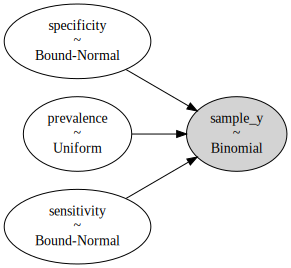

In [ ]:
graph = pm.model_graph.model_to_graphviz(model=normal_priors, formatting="plain")
graph.attr(rankdir='LR', size='8,16')
graph

Now we can do MCMC sampling for our PGM:

In [ ]:
with normal_priors:
  traceNormal = pm.sample(draws=2000, tune=10000, chains=1, target_accept=0.9)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sensitivity, specificity, prevalence]


Sampling 1 chain for 10_000 tune and 2_000 draw iterations (10_000 + 2_000 draws total) took 24 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7363924130107936, but should be close to 0.9. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


Review the chains for each of our variables:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fe555a150>,
      dtype=object)

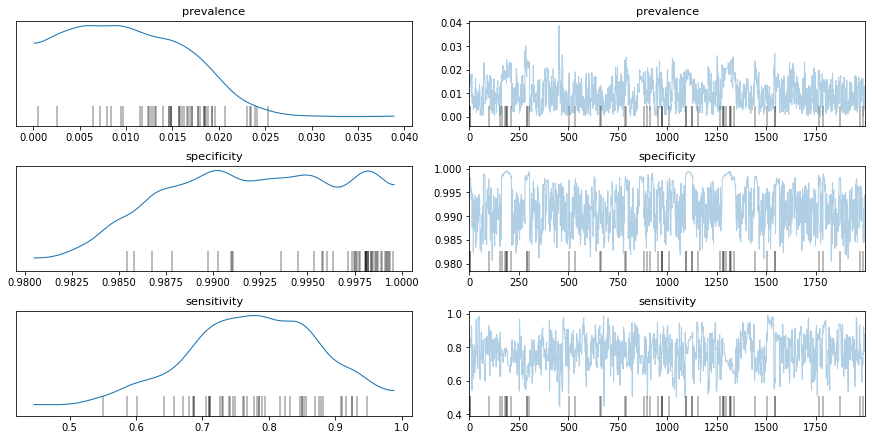

In [ ]:
pm.traceplot(traceNormal)

Recreate the plot from the article. Note they did not show this model, they showed the one in 2e below.

Text(0.5, 0, 'Prevalence, $\\pi$ ')

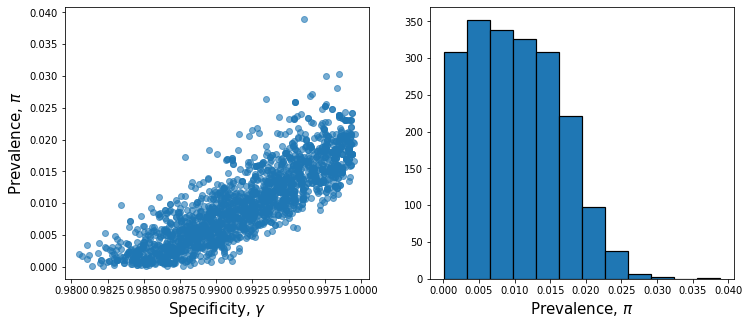

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.scatter(traceNormal["specificity"], traceNormal["prevalence"], alpha=0.6)
ax1.set_ylabel('Prevalence, $\pi$ ', fontsize=15)
ax1.set_xlabel('Specificity, $\gamma$', fontsize=15)
ax2.hist(traceNormal["prevalence"], bins=12, edgecolor='black', linewidth=1.2)
ax2.set_xlabel('Prevalence, $\pi$ ', fontsize=15)

What is the 95% confidence interval for Prevalence?

First, sample from the posterior:

In [ ]:
with normal_priors:
  ppc = pm.sample_posterior_predictive(
      traceNormal,
      var_names=['prevalence', 'specificity', 'sensitivity', 'sample_y'])

Now, request the 95% HDI for prevalence.  

HDI is the highest density interval.  In other words, it is the narrowest interval that contains 95% of the estimates.

In [ ]:
prevalence_hdi95 = pm.stats.hdi(ppc['prevalence'],hdi_prob=0.95)
print("Prevalence has 95% HDI of ({:0.2%},{:0.2%})".format(prevalence_hdi95[0],
                                                           prevalence_hdi95[1]))

Prevalence has 95% HDI of (0.05%,2.07%)


Review the posterior densities, including those for sample_y = number of positive results.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fe1edeb10>,
      dtype=object)

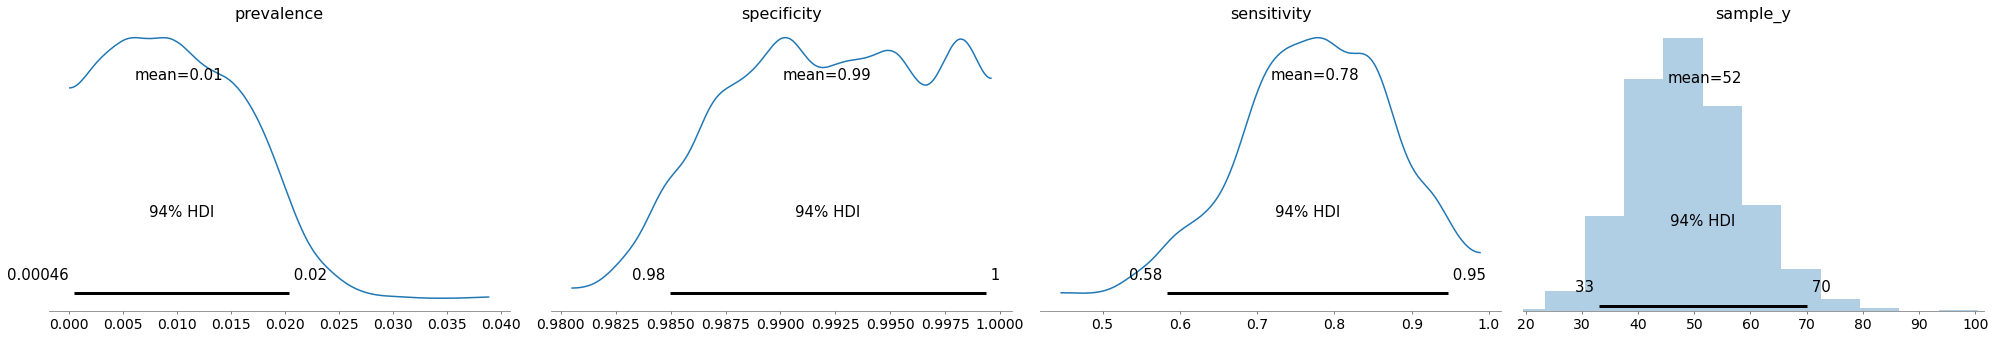

In [ ]:
pm.plot_posterior(ppc);

---
### Section 2e: Bayesian Analysis with Data from Previous Trials
**Paragraphs 6-8**

In the case of the authors reference, they had prior information on specificity and sensitivity from previous trials on known negative and known positive subjects.

Again, we want to model $y \sim \textrm{binomial}(n,p)$.  This time with:
- $p = (1 - \gamma)(1 - \pi) + \delta\pi$
  - $\textrm{PositiveRate} = (1 - \textrm{Specificity})(1 - \textrm{Prevalence}) + \textrm{Sensitivity}\cdot \textrm{Prevalence}$
- $y_\gamma \sim \textrm{binomial}(n_\gamma,\gamma)$
  - specificity
- $y_\delta \sim \textrm{normal}(\mu_\delta,\sigma_\delta)$
  - sensitivity

Also, we want to control $\pi$ (prevalence), $\gamma$ (specificity), and $\delta$ (sensitivity) to be between 0 and 1.  In this instance we do that with a uniform distribution.

The following PyMC3 code block does this.  **Tip** It can be helpful to read the block from bottom to top.

In [ ]:
# Observed Values
sample_y = 50
sample_n = 3330
specificity_y = 399
specificity_n = 401
sensitivity_y = 103
sensitivity_n = 122

with pm.Model() as binomial_priors:

  # priors
  prevalence = pm.Uniform("prevalence", lower=0.0, upper=1.0)
  specificity = pm.Uniform("specificity", lower=0.0, upper=1.0)
  sensitivity = pm.Uniform("sensitivity", lower=0.0, upper=1.0)

  # variables
  sample_p = ((1-specificity)*(1-prevalence)+sensitivity*prevalence)

  # model
  m_sample_y = pm.Binomial("sample_y", n=sample_n, p=sample_p, observed=sample_y)
  m_specificity_y = pm.Binomial("specificity_y", n=specificity_n, p=specificity, observed=specificity_y)
  m_sensitivity_y = pm.Binomial("sensitivity_y", n=sensitivity_n, p=sensitivity, observed=sensitivity_y)

PyMC3 models can be visualized as GraphViz objects. Here is our simple PGM:

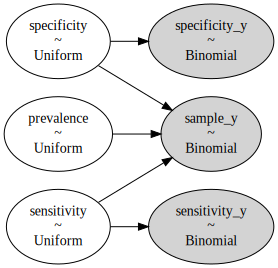

In [ ]:
graph = pm.model_graph.model_to_graphviz(model=binomial_priors, formatting="plain")
graph.attr(rankdir='LR', size='8,16')
graph

The visualizaiton of the models can also include the parameters:

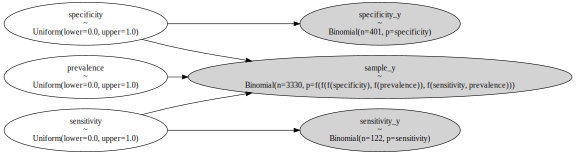

In [ ]:
graph = pm.model_graph.model_to_graphviz(model=binomial_priors, formatting="plain_with_params")
graph.attr(rankdir='LR', size='8,16')
graph

Now we can do MCMC sampling for our PGM:

In [ ]:
with binomial_priors:
  traceBinomial = pm.sample(draws=2000, tune=10000, chains=1, target_accept=0.9)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sensitivity, specificity, prevalence]


Sampling 1 chain for 10_000 tune and 2_000 draw iterations (10_000 + 2_000 draws total) took 21 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Review the chains for each of our variables:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fd01428d0>,
      dtype=object)

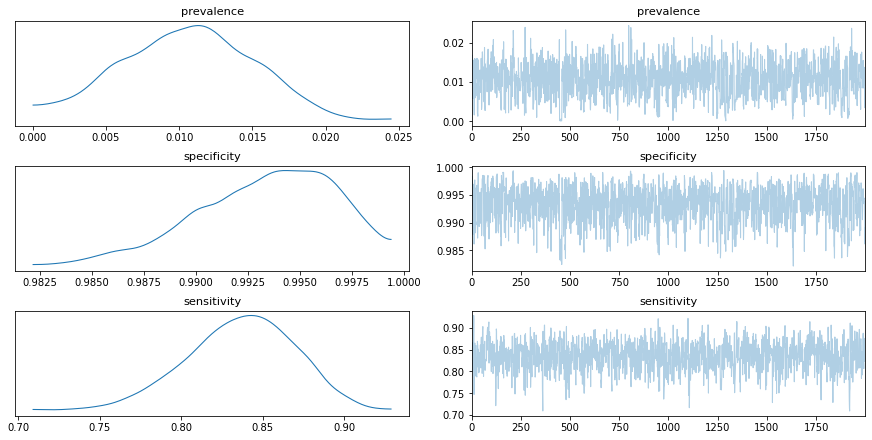

In [ ]:
pm.traceplot(traceBinomial);

Recreate the plot from the article (Figure 1).  Ours, looks very similar.

Text(0.5, 0, 'Prevalence, $\\pi$ ')

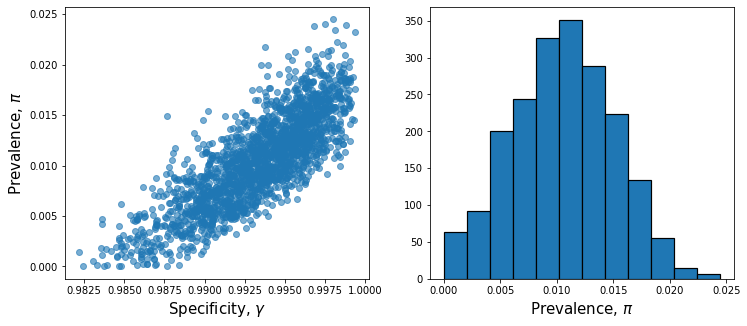

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.scatter(traceBinomial["specificity"], traceBinomial["prevalence"], alpha=0.6)
ax1.set_ylabel('Prevalence, $\pi$ ', fontsize=15)
ax1.set_xlabel('Specificity, $\gamma$', fontsize=15)
ax2.hist(traceBinomial["prevalence"], bins=12, edgecolor='black', linewidth=1.2)
ax2.set_xlabel('Prevalence, $\pi$ ', fontsize=15)

What is the 95% confidence interval for Prevalence?

First, sample from the posterior:

In [ ]:
with binomial_priors:
  ppc = pm.sample_posterior_predictive(
      traceBinomial,
      var_names=['prevalence','specificity','sensitivity','sample_y'])

Now, request the 95% HDI for prevalence.  

HDI is the highest density interval.  In other words, it is the narrowest interval that contains 95% of the estimates.

In [ ]:
prevalence_hdi95 = pm.stats.hdi(ppc['prevalence'],hdi_prob=0.95)
print("Prevalence has 95% HDI of ({:0.1%},{:0.1%})".format(prevalence_hdi95[0],
                                                           prevalence_hdi95[1]))

Prevalence has 95% HDI of (0.2%,1.9%)


The authors also found the 95% interval for $\pi$ (prevalence) to be (0, 1.8%)!

Review the posterior densities, including those for sample_y = number of positive results.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fdbcec390>,
      dtype=object)

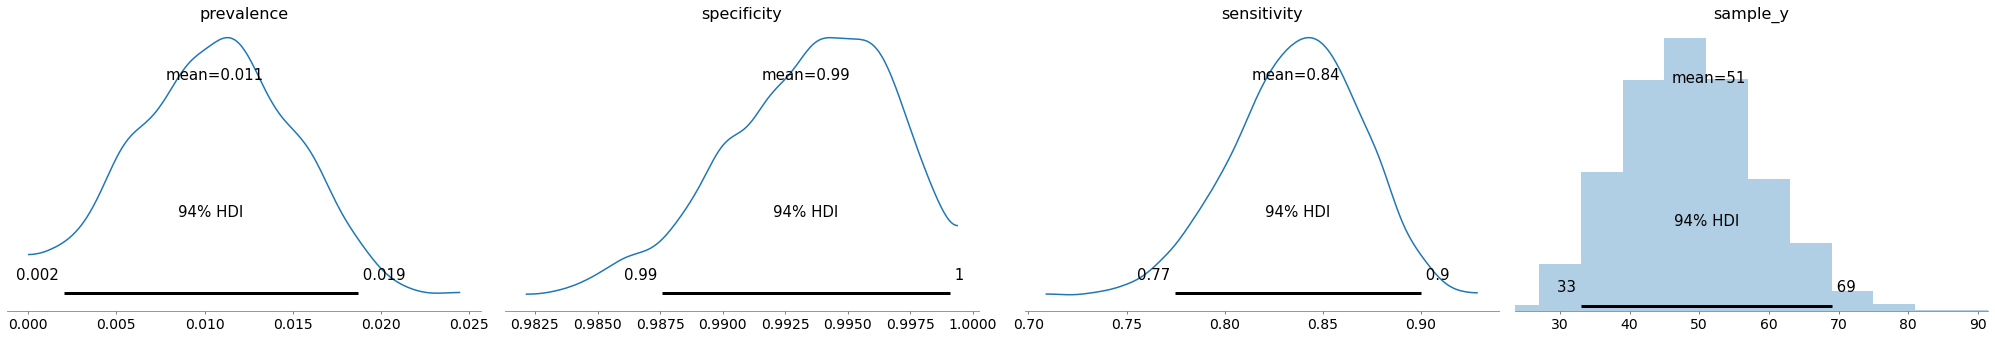

In [ ]:
pm.plot_posterior(ppc);

#### Exercise
Work through Section 2e using different priors for prevalence, specificity, sensitivity.  
- Beta(0.5,0.5)
- Beta(2,2) 
- Beta(1,1)
- Beta(2,10)
- Beta(100,100)

#### Exercise
Compare the intervals for prevalence from Section 1, 2b, 2d, 2e, and the previous exercise.


## Section 3 - Extended Exercise

As an extended exercise review section 3 of the reference.  First, try the various priors mentioned.  Then, design a similar experiment to setup a hierarchical model.